In [1]:
# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(0)
os.environ['CUDA_VISIBLE_DEVICES'] = ''

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(2)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(24)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(26)

# 5. Configure a new global `tensorflow` session
#from keras import backend as K

from tensorflow.python.keras import backend as K

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt   # plotting

from sklearn import preprocessing  #用來標準化刻度
from keras.models import Sequential
from keras.layers import Dense,Dropout  
from sklearn.model_selection import train_test_split
from keras.losses import logcosh, categorical_crossentropy
from keras.utils import to_categorical
from scipy import interp
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
# Import Keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.regularizers import l2
from time import time
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

####################################################################################  x_lstm_validation

T=20

train_cardiac_total=pd.read_csv("mimic_dead_vital_sign_train_"+str(T)+"hours.csv")
test_cardiac_total=pd.read_csv("mimic_dead_vital_sign_test_"+str(T)+"hours.csv")
train_cardiac_base_total=pd.read_csv("mimic_dead_baseline_total_v2.csv")

eicu_cardiac_total=pd.read_csv("eicu_total_"+str(T)+"hours.csv")

total_train=24100 #control+event
total_test=6025 #control+event
train_control=21160 #control


var=6
random=32
smote_ratio=1
near_ratio=1
EPOCH = 3                    # number of epochs
BATCH = 32                      # batch size

dropout=0.4
LR = 0.001                           # learning rate of the gradient descent
LAMBD = 0.001                       # lambda in L2 regularizaion

#####################################################################################
train_cardiac_base_total=train_cardiac_base_total.drop(['subject_id'],axis=1)
train_cardiac_base_total=train_cardiac_base_total.drop(['hadm_id'],axis=1)
train_cardiac_base_total=train_cardiac_base_total.drop(['stay_id'],axis=1)
train_cardiac_base_total=train_cardiac_base_total.drop(['los'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['CA'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['hospDIED'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['cardR'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['DNR'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['CMO'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['DNRDNI'],axis=1)

#train_cardiac_base_total=train_cardiac_base_total.drop(['DNI'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['FullCode'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['indextime'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['ccs9'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['ccs10'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['cardRv2'],axis=1)

###############CXR##############
#train_cardiac_base_total=train_cardiac_base_total.drop(['Atelectasis'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Cardiomegaly'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Consolidation'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Edema'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Enlarged Cardiomediastinum'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Fracture'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Lung Lesion'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Lung Opacity'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['No Finding'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Pleural Effusion'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Pleural Other'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Pneumonia'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Pneumothorax'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Support Devices'],axis=1)
###############CXR##############

#train_cardiac_base_total=pd.get_dummies(data=train_cardiac_base_total,columns=["first_careunit","ethnicity","BMI"])
train_cardiac_base_total=pd.get_dummies(data=train_cardiac_base_total,columns=["first_careunit","ethnicity"])


####################################################################
df_train_base=train_cardiac_base_total[:total_train]
y_train=df_train_base[['eventV3']].values   #取train_labels
y_train_nr=df_train_base[['eventV3']].values   #取train_labels
y_train_base=df_train_base[['eventV3']].values   #取train_labels
y_train_no_smote=df_train_base[['eventV3']].values   #取train_labels
df_train_base=df_train_base.drop(['eventV3'],axis=1)
train_features=df_train_base.values

df_test_base=train_cardiac_base_total[total_train:]
y_test=df_test_base[['eventV3']].values   #取test_labels
y_test_log=df_test_base['eventV3'].values   #取test_labels
df_test_base=df_test_base.drop(['eventV3'],axis=1)
test_features=df_test_base.values

minmax_scale =preprocessing.MinMaxScaler(feature_range=(0,1))

x_train_base=minmax_scale.fit_transform(train_features)
x_test_base=minmax_scale.fit_transform(test_features)

x_train_base_no_smote=minmax_scale.fit_transform(train_features)

#x_train_base=train_features
#x_test_base=test_features

sm = SMOTE(random_state=random, sampling_strategy=smote_ratio)
nr = NearMiss(sampling_strategy=near_ratio) 

x_train_base, y_train_base = sm.fit_sample(x_train_base, y_train_base.ravel())
#x_train_base, y_train_base = nr.fit_sample(x_train_base, y_train_base.ravel())

train_cardiac_total=train_cardiac_total[['vHR','vRR','vsbp','vdbp','vmbp','vspo2']]    
train_cardiac_total=np.array(train_cardiac_total).reshape(total_train,T*var) #轉二維  array
train_cardiac_total= pd.DataFrame(train_cardiac_total)

x_test_lstm=test_cardiac_total[['vHR','vRR','vsbp','vdbp','vmbp','vspo2']].values 
#x_test_lstm=minmax_scale.fit_transform(x_test_lstm)  #規一化
x_test_lstm=np.array(x_test_lstm).reshape(total_test,T,var) 

x_train_lstm, y_train = sm.fit_sample(train_cardiac_total, y_train.ravel())

x_train_lstm_nr, y_train_nr = nr.fit_sample(train_cardiac_total, y_train_nr.ravel())

#x_train_lstm=minmax_scale.fit_transform(x_train_lstm)  #規一化

x_train_lstm=np.array(x_train_lstm).reshape(x_train_lstm.shape[0],T,var) #轉三維  total

x_train_lstm_nr=np.array(x_train_lstm_nr).reshape(x_train_lstm_nr.shape[0],T,var) #轉三維  total

x_train_lstm_no_smote=np.array(train_cardiac_total).reshape(train_cardiac_total.shape[0],T,var) #轉三維  total

print('timeline:',train_cardiac_total.shape)
print('baseline:',df_train_base.shape)

print('timeline:',x_train_lstm.shape)
print('baseline:',x_train_base.shape)
print('label:',y_train.shape)

print('timeline:',x_test_lstm.shape)
print('baseline:',x_test_base.shape)
print('label:',y_test.shape)

print('timeline_no_smote:',x_train_lstm_no_smote.shape)
print('baseline_no_smote:',x_train_base_no_smote.shape)
print('label_no_smote:',y_train_no_smote.shape)


print('timeline_nr:',x_train_lstm_nr.shape)
print('label_nr:',y_train_nr.shape)
#print(df_train_base.columns)


Using TensorFlow backend.


timeline: (24100, 120)
baseline: (24100, 70)
timeline: (42320, 20, 6)
baseline: (42320, 70)
label: (42320,)
timeline: (6025, 20, 6)
baseline: (6025, 70)
label: (6025, 1)
timeline_no_smote: (24100, 20, 6)
baseline_no_smote: (24100, 70)
label_no_smote: (24100, 1)
timeline_nr: (5880, 20, 6)
label_nr: (5880,)


In [2]:
print(x_train_lstm.shape)
print(y_train.shape)

LAYERS = [8,8,8,1]                # number of units in hidden and output layers
M_TRAIN = x_train_lstm.shape[0]           # number of training examples (2D)
#M_VALIDATION =x_valid_lstm_new.shape[0]  
M_TEST = x_test_lstm.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = x_train_lstm.shape[2]                 # number of features

#BATCH = M_TRAIN                          # batch size
DP = 1                            # dropout rate
RDP = 1                          # recurrent dropout rate
print(f'layers={LAYERS}, train_examples={M_TRAIN}, test_examples={M_TEST}')
print(f'batch = {BATCH}, timesteps = {T}, features = {N}, epochs = {EPOCH}')
print(f'lr = {LR}, lambda = {LAMBD}, dropout = {DP}, recurr_dropout = {RDP}')
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


# Build the Model
model_smote = Sequential()

model_smote.add(LSTM(input_shape=(T, N), units=LAYERS[0],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
              # dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_smote.add(Dropout(dropout))
model_smote.add(BatchNormalization())


model_smote.add(LSTM(units=LAYERS[1],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
              # dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_smote.add(Dropout(dropout))
model_smote.add(BatchNormalization())

model_smote.add(LSTM(units=LAYERS[2],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
              # dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False,name="LAYERS"
              ))
model_smote.add(Dropout(dropout))
model_smote.add(BatchNormalization())


model_smote.add(Dense(units=LAYERS[3], activation='sigmoid'))

# Compile the model with Adam optimizer
model_smote.compile(loss='binary_crossentropy', metrics=['accuracy',f1_m,precision_m], optimizer=Adam(lr=LR))

print(model_smote.summary())

# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)

# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_acc', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)
# Train the model. 
# The dataset is small for NN - let's use test_data for validation
start = time()

##################################################

History = model_smote.fit(x_train_lstm, y_train,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_split=0.2,
                    #validation_data=(x_valid_lstm_new[:M_VALIDATION], y_valid_lstm_new[:M_VALIDATION]),
                    #validation_data=(x_test_lstm[:M_TEST], y_test[:M_TEST]),
                    shuffle=True,
                    verbose=2,
                    callbacks=[lr_decay, early_stop])

print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)
# Evaluate the model:
train_loss, train_acc, train_f1_score, train_precision = model_smote.evaluate(x_train_lstm, y_train,
                                       batch_size=BATCH, verbose=0)

test_loss, test_acc, test_f1_score, test_precision = model_smote.evaluate(x_test_lstm[:M_TEST], y_test[:M_TEST],
                                     batch_size=BATCH, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')




(42320, 20, 6)
(42320,)
layers=[8, 8, 8, 1], train_examples=42320, test_examples=6025
batch = 32, timesteps = 20, features = 6, epochs = 3
lr = 0.001, lambda = 0.001, dropout = 1, recurr_dropout = 1
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20, 8)             480       
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 8)             0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 20, 8)             32        
_________________________________________________________________
lstm_2 (LSTM)                (None, 20, 8)             544       
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 8)             0         
_____________________________________________________

C:\Users\Tony\anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,val_f1_m,val_precision_m,loss,accuracy,f1_m,precision_m,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 49s - loss: 0.5001 - accuracy: 0.7903 - f1_m: 0.6747 - precision_m: 0.8019 - val_loss: 0.4467 - val_accuracy: 0.7828 - val_f1_m: 0.8765 - val_precision_m: 1.0000
Epoch 3/3
 - 65s - loss: 0.4767 - accuracy: 0.7984 - f1_m: 0.6927 - precision_m: 0.8045 - val_loss: 0.9194 - val_accuracy: 0.5224 - val_f1_m: 0.6821 - val_precision_m: 1.0000
-----------------------------------------------------------------
Training was completed in 180.24 secs
-----------------------------------------------------------------
-----------------------------------------------------------------
train accuracy = 74.3384%
test accuracy = 90.5892%
test error = 567 out of 6025 examples


In [3]:
y_pred_smote= model_smote.predict(x_test_lstm)

predict_test_smote=[]
for i in range(y_pred_smote.shape[0]): 
    if y_pred_smote[i]>0.5:
        predict_test_smote.append(1)
    else:
        predict_test_smote.append(0)
predict_test_smote = np.array(predict_test_smote)
print(predict_test_smote)

[0 0 0 ... 0 0 0]


In [4]:
y_test_1D=np.array(y_test).reshape(total_test)

#predict_train_lstm = model.predict(x_train_lstm)
#predict_train_lstm=np.array(predict_train_lstm).reshape(total_train.shape[0]) #37536

pd.crosstab(y_test_1D,predict_test_smote,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test_smote)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 
accuracy= (cm1[0,0]+cm1[1,1])/(cm1[0,0]+cm1[0,1]+cm1[1,1]+cm1[1,0])   #FPR
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
ppv =  cm1[1,1]/(cm1[0,1]+cm1[1,1])   
npv =  cm1[0,0]/(cm1[0,0]+cm1[1,0])  

print('accuracy:',accuracy)
print('specificity:',specificity)
print('sensitivity:',sensitivity)
print('ppv:',ppv)
print('npv:',npv)


Confusion Matrix : 
 [[5023  266]
 [ 301  435]]
accuracy: 0.9058921161825726
specificity: 0.9497069389298544
sensitivity: 0.5910326086956522
ppv: 0.6205420827389444
npv: 0.9434635612321562


<Figure size 432x288 with 0 Axes>

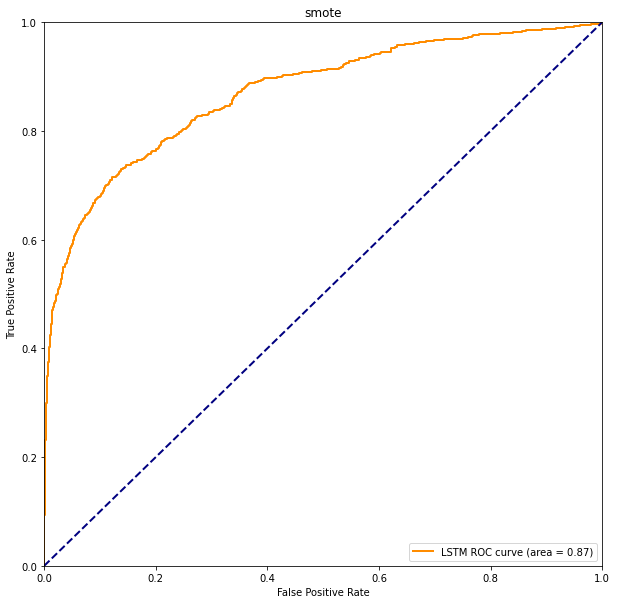

In [5]:
# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_test, y_pred_smote) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='LSTM ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('smote')
plt.legend(loc="lower right")

plt.show()

In [6]:
from keras import backend as K
get_11rd_layer_output = K.function([model_smote.layers[0].input],
         [model_smote.layers[6].output])
layer_output = get_11rd_layer_output([x_train_lstm])[0]

layer_output_test = get_11rd_layer_output([x_test_lstm])[0]

print(layer_output.shape)

print(layer_output)

print(layer_output_test.shape)

print(layer_output_test)

(42320, 8)
[[ 0.1645114  -0.26335308  0.20288421 ...  0.22595833 -0.2459811
  -0.32392657]
 [ 0.24501051 -0.25799555  0.22866678 ...  0.22156169 -0.27386823
  -0.33776033]
 [ 0.15781975 -0.18152657  0.15102674 ...  0.1732676  -0.19118834
  -0.23458664]
 ...
 [ 0.19863293 -0.23673435  0.06873203 ...  0.12690008  0.09914808
  -0.05510673]
 [-0.05370537  0.08836288  0.05196857 ...  0.03172836 -0.01304627
   0.01899433]
 [ 0.1264652   0.05469431  0.09452234 ... -0.03285715 -0.12345137
  -0.08649537]]
(6025, 8)
[[ 0.21535328 -0.2530653   0.22744271 ...  0.22842278 -0.28582907
  -0.3547149 ]
 [ 0.24504924 -0.2752809   0.2213644  ...  0.22680743 -0.2679779
  -0.33975017]
 [ 0.24336867 -0.26832888  0.21645582 ...  0.21955661 -0.26407424
  -0.33117065]
 ...
 [ 0.21339294 -0.29521665  0.12670091 ...  0.20000468 -0.0052789
  -0.19210893]
 [-0.08958947 -0.01259523  0.09883091 ...  0.14285049 -0.15637547
  -0.18578291]
 [ 0.1393595  -0.04425074  0.12308978 ...  0.06613596 -0.20570756
  -0.19622068]

In [7]:
x_train_base_combine=np.hstack((x_train_base,layer_output))
x_test_base_combine=np.hstack((x_test_base,layer_output_test))

In [8]:
print(x_train_base_combine.shape)
print(x_test_base_combine.shape)

(42320, 78)
(6025, 78)


In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc  ###計算roc和auc
from sklearn.model_selection import train_test_split
from sklearn import metrics,ensemble
from sklearn import model_selection

gbm = xgb.XGBClassifier()

xgb_params = {
#'learning_rate': [0.1,0.2,0.5],
#'n_estimators': [30,50,100],
#'max_depth': [5,10,20],
'n_estimators': [3,4,5],
'max_depth': [3,4,5]
#'n_estimators': [3],
#'max_depth': [3]
#'n_estimators': [5],
#'max_depth': [30]
#'n_estimators': [30],
#'max_depth': [5]
#'n_estimators': [30],
#'max_depth': [30]
# 'alpha': [0.4,0.6],
 }

xg_reg = model_selection.GridSearchCV(gbm, xgb_params, cv=5,scoring="roc_auc")
xg_reg.fit(x_train_base_combine,y_train)

y_pred = xg_reg.predict(x_test_base_combine)
y_pred_xg = xg_reg.predict_proba(x_test_base_combine)
y_pred_xg = y_pred_xg[:, 1]


In [10]:
def roc_curve_and_score(y_test, pred_proba):
    fpr, tpr, _ = roc_curve(y_test.ravel(), pred_proba.ravel())
    roc_auc = roc_auc_score(y_test.ravel(), pred_proba.ravel())
    return fpr, tpr, roc_auc


predict_test=[]
for i in range(y_pred_xg.shape[0]): 
    if y_pred_xg[i]>0.5:
        predict_test.append(1)
    else:
        predict_test.append(0)
predict_test = np.array(predict_test)

y_test_1D=np.array(y_test).reshape(total_test)

pd.crosstab(y_test_1D,predict_test,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR

fpr,tpr,roc_auc = roc_curve_and_score(y_test, y_pred_xg) ###計算真正率和假正率
accuracy=(cm1[0,0]+cm1[1,1])/(cm1[0,0]+cm1[0,1]+cm1[1,0]+cm1[1,1])

print('Sensitivity : %0.2f' % sensitivity )
print('Specificity :%0.2f' % specificity)

print('AUC : %0.2f' % roc_auc)  #AUC

print('accuracy :%0.2f' % accuracy)


print(xg_reg.best_params_)
print(xg_reg.best_score_)

Confusion Matrix : 
 [[4700  589]
 [ 158  578]]
Sensitivity : 0.79
Specificity :0.89
AUC : 0.91
accuracy :0.88
{'max_depth': 5, 'n_estimators': 5}
0.9530328941255928


In [11]:
from sklearn.model_selection import train_test_split
from sklearn import metrics,ensemble
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

forest = ensemble.RandomForestClassifier()

rf_params = {
'n_estimators': [15,20,25],
'max_depth': [4,5,6,7]
#'n_estimators': [5],
#'max_depth': [5]
 }

forest = model_selection.GridSearchCV(forest, rf_params, cv=5)
forest_fit=forest.fit(x_train_base_combine,y_train)


prob_predict_y_validation = forest.predict_proba(x_test_base_combine)#给出带有概率值的结果，每个点所有label的概率和为1
y_score = prob_predict_y_validation[:, 1]


In [12]:
predict_test=[]
for i in range(y_score.shape[0]): 
    if y_score[i]>0.5:
        predict_test.append(1)
    else:
        predict_test.append(0)
predict_test = np.array(predict_test)

y_test_1D=np.array(y_test).reshape(6025)

pd.crosstab(y_test_1D,predict_test,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR

accuracy=(cm1[0,0]+cm1[1,1])/(cm1[0,0]+cm1[0,1]+cm1[1,0]+cm1[1,1])

print('Sensitivity : %0.2f' % sensitivity )
print('Specificity :%0.2f' % specificity)

fpr,tpr,roc_auc = roc_curve_and_score(y_test, y_score) ###計算真正率和假正率

print('AUC : %0.2f' % roc_auc)  #AUC

print('accuracy :%0.2f' % accuracy)

print(forest.best_params_)
print(forest.best_score_)

Confusion Matrix : 
 [[4814  475]
 [ 167  569]]
Sensitivity : 0.77
Specificity :0.91
AUC : 0.92
accuracy :0.89
{'max_depth': 7, 'n_estimators': 15}
0.8779536862003781


In [13]:
from sklearn.linear_model import LogisticRegressionCV

logregCV = LogisticRegressionCV(cv=5)
logregCV.fit(x_train_base_combine, y_train)


C:\Users\Tony\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Tony\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/

C:\Users\Tony\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Tony\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/

LogisticRegressionCV(cv=5)

In [14]:
logreg_test_y_predicted_pro_CV = logregCV.predict_proba(x_test_base_combine)

log_score_CV = logreg_test_y_predicted_pro_CV[:, 1]

predict_test_CV=[]
for i in range(log_score_CV.shape[0]): 
    if log_score_CV[i]>0.5:
        predict_test_CV.append(1)
    else:
        predict_test_CV.append(0)
predict_test_CV = np.array(predict_test_CV)

#print(predict_test)

from sklearn.metrics import accuracy_score, f1_score,precision_score,recall_score,confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test_CV)

sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR

#print('Precision:',precision_score(y_test_1, predict_test))
#print('Recall:', recall_score(y_test_1, predict_test))
#print('f1-score: %f' % f1_score(y_test_1, predict_test))
print('Accuracy: %f' % accuracy_score(y_test, predict_test_CV))
print('Sensitivity : %0.2f' % sensitivity )
print('Specificity :%0.2f' % specificity)

pd.crosstab(y_test_1D,predict_test_CV,rownames=['label'],colnames=['predict'])

Accuracy: 0.860581
Sensitivity : 0.82
Specificity :0.87


predict,0,1
label,,
0,4579,710
1,130,606


In [15]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=2)
neigh.fit(x_train_base_combine, y_train)

KNeighborsClassifier(n_neighbors=2)

In [16]:
nei_test_y_predicted = neigh.predict(x_test_base_combine)
predict_test=[]
for i in range(nei_test_y_predicted.shape[0]): 
    if nei_test_y_predicted[i]>0.5:
        predict_test.append(1)
    else:
        predict_test.append(0)
predict_test = np.array(predict_test)

#print(predict_test)

from sklearn.metrics import accuracy_score, f1_score,precision_score,recall_score,confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test)

sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR

#print('Precision:',precision_score(y_test_1, predict_test))
#print('Recall:', recall_score(y_test_1, predict_test))
#print('f1-score: %f' % f1_score(y_test_1, predict_test))
print('Accuracy: %f' % accuracy_score(y_test, predict_test))
print('Sensitivity : %0.2f' % sensitivity )
print('Specificity :%0.2f' % specificity)

pd.crosstab(y_test_1D,predict_test,rownames=['label'],colnames=['predict'])


Accuracy: 0.871369
Sensitivity : 0.61
Specificity :0.91


predict,0,1
label,,
0,4804,485
1,290,446


In [17]:
from sklearn import  svm, preprocessing, metrics 
from sklearn.svm import SVC
from sklearn import svm
from sklearn.preprocessing import StandardScaler

svm = svm.SVC(probability=True)
svm.fit(x_train_base_combine,y_train)
svm_y_predicted = svm.predict(x_test_base_combine)

svm_y_predicted_pro = svm.predict_proba(x_test_base_combine)

svm_score=svm_y_predicted_pro[:,1]

In [18]:
predict_test=[]
for i in range(svm_score.shape[0]): 
    if svm_score[i]>0.5:
        predict_test.append(1)
    else:
        predict_test.append(0)
predict_test = np.array(predict_test)

#print(predict_test)

from sklearn.metrics import accuracy_score, f1_score,precision_score,recall_score,confusion_matrix

cm1 = confusion_matrix(y_test,predict_test)

sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR

#print('Precision:',precision_score(y_test_1, predict_test))
#print('Recall:', recall_score(y_test_1, predict_test))
#print('f1-score: %f' % f1_score(y_test_1, predict_test))
print('Accuracy: %f' % accuracy_score(y_test, predict_test))
print('Sensitivity : %0.2f' % sensitivity )
print('Specificity :%0.2f' % specificity)

pd.crosstab(y_test_1D,predict_test,rownames=['label'],colnames=['predict'])


Accuracy: 0.921328
Sensitivity : 0.70
Specificity :0.95


predict,0,1
label,,
0,5037,252
1,222,514


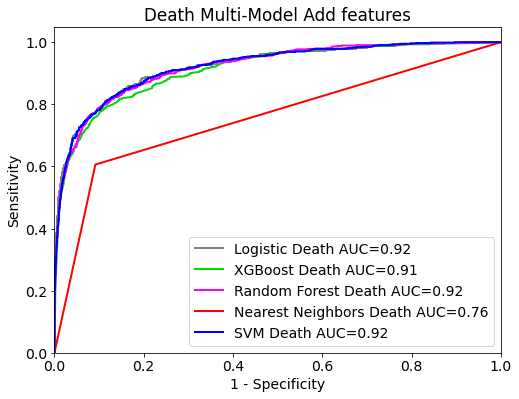

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc  ###計算roc和auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 14})

#plt.grid()

fpr, tpr, roc_auc = roc_curve_and_score(y_test, log_score_CV)
plt.plot(fpr, tpr, color='gray', lw=2,
         label='Logistic Death AUC={0:.2f}'.format(roc_auc))

fpr, tpr, roc_auc = roc_curve_and_score(y_test, y_pred_xg)
plt.plot(fpr, tpr, color='#00db00', lw=2,
         label='XGBoost Death AUC={0:.2f}'.format(roc_auc))

fpr, tpr, roc_auc = roc_curve_and_score(y_test, y_score)
plt.plot(fpr, tpr, color='#ff00ff', lw=2,
         label='Random Forest Death AUC={0:.2f}'.format(roc_auc))

fpr, tpr, roc_auc = roc_curve_and_score(y_test, nei_test_y_predicted)
plt.plot(fpr, tpr, color='red', lw=2,
         label='Nearest Neighbors Death AUC={0:.2f}'.format(roc_auc))


fpr, tpr, roc_auc = roc_curve_and_score(y_test, svm_score)
plt.plot(fpr, tpr, color='blue', lw=2,
         label='SVM Death AUC={0:.2f}'.format(roc_auc))

plt.title('Death Multi-Model Add features')
plt.legend(loc="lower right")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')

plt.show()